In [6]:
!python3 -m pip install torch torchvision torchaudio
!python3 -m pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("../data/cleaned_github_users.csv")

# Filter users with non-empty bios
bio_df = df[df['Bio'].notna() & (df['Bio'] != 'No Bio Provided')].reset_index(drop=True)

# Load a pretrained transformer model for sentence similarity
model = SentenceTransformer('all-MiniLM-L6-v2')


In [4]:
bio_embeddings = model.encode(bio_df['Bio'].tolist(), convert_to_tensor=True)


In [7]:
def recommend_bio_semantic(username, top_k=5):
    if username not in bio_df['Username'].values:
        print("❌ Username not found or no bio available.")
        return pd.DataFrame()

    idx = bio_df.index[bio_df['Username'] == username][0]
    query_embedding = bio_embeddings[idx].unsqueeze(0)

    scores = util.pytorch_cos_sim(query_embedding, bio_embeddings)[0]

    top_results = scores.argsort(descending=True)[1:top_k+10]  # buffer for dedup
    recs = bio_df.iloc[top_results.cpu().numpy()].copy()
    recs['similarity'] = scores[top_results].cpu().numpy()

    # Drop duplicate usernames, keeping highest score
    recs = recs.sort_values(by='similarity', ascending=False).drop_duplicates(subset='Username')

    return recs[['Username', 'Bio', 'Location', 'Profile_URL', 'similarity']].head(top_k)



In [8]:
recommend_bio_semantic("abhay")


,Username,Bio,Location,Profile_URL,similarity
24,abhay,nostr: npub170uwqlxtwefytnpvek42qsazs0wq0ej856...,"San Francisco, CA",https://github.com/abhay,1.000000
994,nickolai,nostr: npub1d0ne05dgy7lnlazh7namumcj0fzg7ja6yk...,"Kutaisi, ex. St.-Petersburg, Russia",https://github.com/nickolai,0.850408
14,uggedal,created_at: 2008-01-27T22:18:57Z,"Oslo, Norway",https://github.com/uggedal,0.369992
291,cpjolicoeur,GitHub ID #863,"Rhode Island, USA",https://github.com/cpjolicoeur,0.363498
1040,subtleGradient,JW. Frontend 1st Full stack AI wrangler.\r\n\r...,"Sarasota, Florida",https://github.com/subtleGradient,0.357270


In [9]:
# Save top_k semantic scores for all users
semantic_bio_scores = []

for user in bio_df['Username'].unique():
    try:
        recs = recommend_bio_semantic(user, top_k=5)
        for _, row in recs.iterrows():
            semantic_bio_scores.append({
                'Username': row['Username'],
                'target': user,
                'semantic_bio_score': row['similarity']
            })
    except:
        continue  # Skip if user has no embeddings

# Convert to DataFrame and save
semantic_bio_df = pd.DataFrame(semantic_bio_scores)
semantic_bio_df.to_csv("../data/bio_semantic_scores.csv", index=False)
print("✅ Semantic Bio similarity scores saved to bio_semantic_scores.csv")


✅ Semantic Bio similarity scores saved to bio_semantic_scores.csv


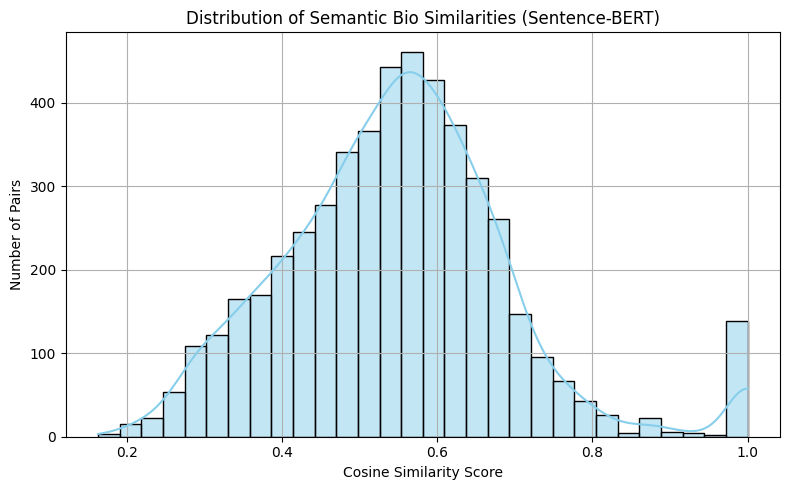

📈 Average Semantic Similarity: 0.5472


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved semantic similarity scores
semantic_bio_df = pd.read_csv("../data/bio_semantic_scores.csv")

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(semantic_bio_df['semantic_bio_score'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Semantic Bio Similarities (Sentence-BERT)")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Number of Pairs")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print average similarity
print(f"📈 Average Semantic Similarity: {semantic_bio_df['semantic_bio_score'].mean():.4f}")


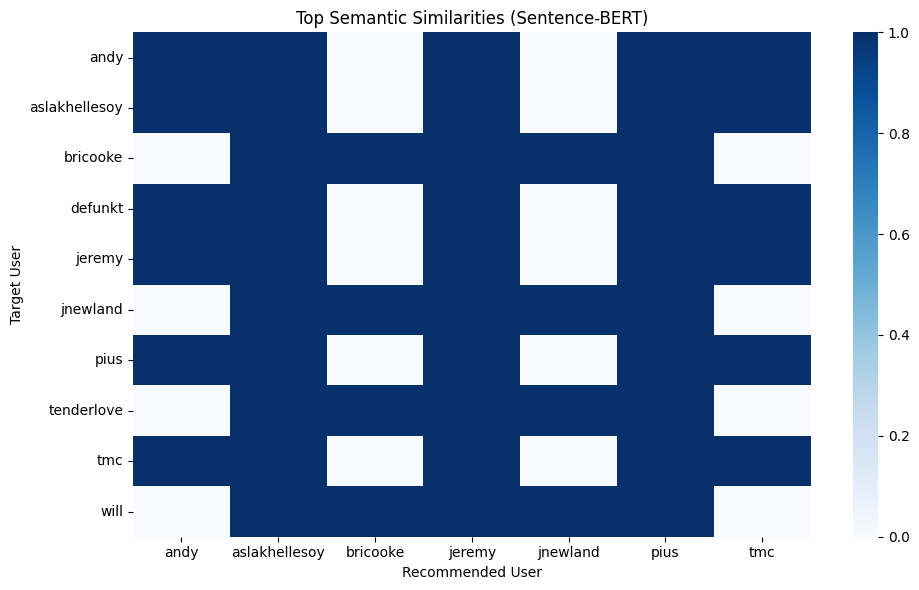

In [3]:
# Example: Top 10 targets with the highest average semantic scores
top_targets = (
    semantic_bio_df.groupby("target")["semantic_bio_score"]
    .mean().sort_values(ascending=False).head(10).index.tolist()
)

pivot_table = semantic_bio_df[semantic_bio_df["target"].isin(top_targets)]
pivot_table = pivot_table.pivot(index="target", columns="Username", values="semantic_bio_score").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=False, cmap="Blues")
plt.title("Top Semantic Similarities (Sentence-BERT)")
plt.xlabel("Recommended User")
plt.ylabel("Target User")
plt.tight_layout()
plt.show()
